In [1]:
import numpy as np
import random
import copy
import time
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from unityagents import UnityEnvironment

import matplotlib.pyplot as plt
%matplotlib inline

### Hyper-parameters
* BUFFER_SIZE - experience replay buffer size
* BATCH_SIZE - minibatch size to retirieve from experience replay
* GAMMA - discount rate
* TAU - parameter for soft update that determines how fast target network is merged into local
* LR_ACTOR - learning rate for actor network
* LR_CRITIC - learning rate for critic network
* WEIGHT_DECAY - L2 regularization weight decay factor
* LEARN_EVERY - determines timestep interval to learn networks
* LEARN_NUM - number of learning procedures 
* OU_SIGMA - Ornstein-Uhlenbeck noise parameter
* OU_THETA - Ornstein-Uhlenbeck noise parameter
* EPSILON - parameter that controls noice effect for exploration/exploitation
* EPSILON_DECAY - decay rate for EPSILON

In [2]:
BUFFER_SIZE = int(1e6)
BATCH_SIZE = 128       
GAMMA = 0.99          
TAU = 1e-3             
LR_ACTOR = 1e-3      
LR_CRITIC = 1e-3      
WEIGHT_DECAY = 0     
LEARN_EVERY = 20      
LEARN_NUM = 10      
OU_SIGMA = 0.2        
OU_THETA = 0.15      
EPSILON = 1.0         
EPSILON_DECAY = 1e-6 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Agent class
A core class that implement the actual DDPG algorithm.

In a constructor it creates 2 pairs of network (1 for actor and another for critic), noise class for more exploration and experience replay buffer.

Important functions:
* `step` - records an state-action-reward tuple into experice replay buffer and starts network training of specified interval
* `act` - retrieves action for a state from action local network
* `learn` - does the actual learning by implementing DDPG algorithm:
	* step 1: getting predicted next-state actions and Q values from target models
	* step 2: computing Q targets for current states 
	* step 3: computing critic loss
	* step 4: minimizing critic loss and traing the network
	* step 5: computing actor loss (with '-' sign as this is gradient ascent
	* step 6: minimizing actor loss and traing the network
	* step 7: applying soft update and slowly mering local networks into target

In [3]:
class Agent():
    def __init__(self, state_size, action_size, random_seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        self.epsilon = EPSILON

        # actor networks
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # critic networks
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        self.noise = OUNoise(action_size, random_seed)

        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)

    def load_actor_model(self, path):
        self.actor_local.load_state_dict(torch.load(path))
        
    def load_critic_model(self, path):
        self.critic_local.load_state_dict(torch.load(path))

    def step(self, state, action, reward, next_state, done, timestep):
        self.memory.add(state, action, reward, next_state, done)

        if len(self.memory) > BATCH_SIZE and timestep % LEARN_EVERY == 0:
            for _ in range(LEARN_NUM):
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, add_noise=True):
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.epsilon * self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        # critic update
        # step 1: 
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # step 2:
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # step 3:
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # step 4:
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # actor update
        # step 5:
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # step 6:
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # step 7:
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)

        # ---------------------------- update noise ---------------------------- #
        self.epsilon -= EPSILON_DECAY
        self.noise.reset()

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

Utility that helps to implement Ornstein-Uhlenbeck noise for better exproration.

In [4]:
class OUNoise:
    def __init__(self, size, seed, mu=0., theta=OU_THETA, sigma=OU_SIGMA):
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        self.state = copy.copy(self.mu)

    def sample(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        
        return self.state

Experience replay buffer implementation that stores and generates tuples for network training.

In [5]:
class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size) 
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

2 classes that implement Actor and Critic. These are enural networks with 2 hidden units each.

Actor learns and returns a policy (best action for a given state).
Critic learn Q value for a state-value pair.

In [6]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    
    return (-lim, lim)


class Actor(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_units=400, fc2_units=300):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)

        self.fc1 = nn.Linear(state_size, fc1_units)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        x = F.relu(self.bn1(self.fc1(state)))
        x = F.relu(self.fc2(x))
        
        return F.tanh(self.fc3(x))


class Critic(nn.Module):
    def __init__(self, state_size, action_size, seed, fcs1_units=400, fc2_units=300):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)

        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.bn1 = nn.BatchNorm1d(fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        xs = F.relu(self.bn1(self.fcs1(state)))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        
        return self.fc3(x)

A utility function that initiates Unity environment, ad agent and starts the training.

In [7]:
def ddpg(n_episodes=500, max_steps=1000, solved_score=30.0, max_last_scores=100,
         actor_path='actor_model.pth', critic_path='critic_model.pth'):

    last_scores = deque(maxlen=max_last_scores) 
    all_scores = [] 

    for i_episode in range(1, n_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations  
        scores = np.zeros(num_agents) 
        agent.reset()

        for t in range(max_steps):
            actions = agent.act(states, add_noise=True) 
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations 
            rewards = env_info.rewards 
            dones = env_info.local_done 

            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done, t)
                
            states = next_states
            scores += rewards
            
            if np.any(dones): 
                break
    
        average_score = np.mean(scores)
        last_scores.append(average_score) 
        
        last_average_scores = np.mean(average_score)
        all_scores.append(last_average_scores) 

        print("\repisode {}/{}, average score: {:.2f}".format(i_episode, n_episodes, last_average_scores))

        if last_average_scores >= solved_score:
            print("\nsolved in {} episodes".format(i_episode))
            
            torch.save(agent.actor_local.state_dict(), actor_path)
            torch.save(agent.critic_local.state_dict(), critic_path)
            
            fig = plt.figure()
            ax = fig.add_subplot(111)
            plt.plot(np.arange(len(all_scores)), all_scores)
            plt.ylabel("score")
            plt.xlabel("episode #")
            plt.show()
            
            break

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


/home/mexxik/.virtualenvs/drl-project-2/lib/python3.5/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


episode 1/500, average score: 0.90


episode 2/500, average score: 2.01


episode 3/500, average score: 4.36


episode 4/500, average score: 5.06


episode 5/500, average score: 6.21


episode 6/500, average score: 6.59


episode 7/500, average score: 7.20


episode 8/500, average score: 8.04


episode 9/500, average score: 8.31


episode 10/500, average score: 11.34


episode 11/500, average score: 12.71


episode 12/500, average score: 12.42


episode 13/500, average score: 13.06


episode 14/500, average score: 13.05


episode 15/500, average score: 15.16


episode 16/500, average score: 17.57


episode 17/500, average score: 19.26


episode 18/500, average score: 17.93


episode 19/500, average score: 18.22


episode 20/500, average score: 18.18


episode 21/500, average score: 21.96


episode 22/500, average score: 22.57


episode 23/500, average score: 24.81


episode 24/500, average score: 23.56


episode 25/500, average score: 22.48


episode 26/500, average score: 23.14


episode 27/500, average score: 25.85


episode 28/500, average score: 29.12


episode 29/500, average score: 28.70


episode 30/500, average score: 28.98


episode 31/500, average score: 29.96


episode 32/500, average score: 30.21

solved in 32 episodes


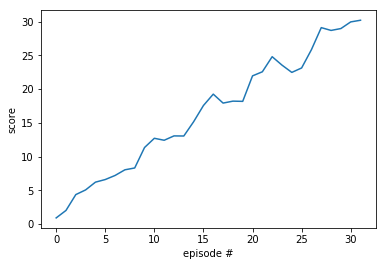

In [8]:
env = UnityEnvironment(file_name="more_agents/Reacher.x86_64")

brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])


agent = Agent(state_size=state_size, action_size=action_size, random_seed=1)
ddpg()

Test the agent

In [7]:
env = UnityEnvironment(file_name="more_agents/Reacher.x86_64")

brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)    

agent = Agent(state_size=state_size, action_size=action_size, random_seed=1)
agent.load_actor_model("actor_model.pth")

while True:
    actions = agent.act(states, add_noise=False)          # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


/home/mexxik/.virtualenvs/drl-project-2/lib/python3.5/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Total score (averaged over agents) this episode: 36.53449918339029


### Results and Future Improvements.

This project is an example Deep Deterministic Policy Gradient (DDPG) algorithm implemented for continuous control problem. Current implementation solved the enviroment in 32 episodes and shows consistent results during a test run.

Here are some possible improvements and exploration paths:
* Try another environment with 1 agent. It will generate less data and might require its own set of hyperparameters.
* Explore other algorithms, like PPO or more advances and modern like suggested in the lesson (Trust Region Policy Optimization (TRPO) and Truncated Natural Policy Gradient (TNPG),  Distributed Distributional Deterministic Policy Gradients (D4PG))
* Experiment with hyperparameters:
	* LEARN_EVERY and LEARN_NUM will allow to specify how ofter the network will be trained. Maybe try setting it to more "agressive" (frequest mode), even though it was reported that this approach is not stable.
	* Play with explotation/exploration by tweaking OU noise.
	* Previous lessons and projects showed that experience buffer size affect on the performance.
	* Would be interesting to try increasing batch size for training and adding more regularization (L2) to avoid overfitting. 